#Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it is time to learn about a new kind of transfer learning: fine-tuning.

In [ ]:
import tensorflow as tf
tf.__version__

'2.9.0'

In [ ]:
#downgrade tensorflow to avoid serialize error
!pip install tensorflow==2.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#check if we are using a GPU

##Creating helper functions

In previous notebook, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious 

So it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere)

We've done this for some of the functions we've used previously

In [ ]:
#get helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2023-04-24 08:49:44--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-24 08:49:44 (79.4 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
#import helper function we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

>**Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_function.py`, so you will have to redownload it if you want access to your helper functions 

## Let's get some data

This time we're going to see how we can use the pretrained models within tf.keras.applications and apply them to our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
#Get 10% of training data of 10 classes of food
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip


--2023-04-24 08:49:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 74.125.199.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   170MB/s    in 0.9s    

2023-04-24 08:49:46 (170 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:

unzip_data("10_food_classes_10_percent.zip")

In [ ]:
#check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [ ]:
#Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory= train_dir,
                                                                         image_size = IMG_SIZE,
                                                                         label_mode = "categorical",
                                                                         batch_size = BATCH_SIZE)


test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = "categorical",
                                                                batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
#Check out class name of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[3.53325920e+01 2.53325882e+01 2.33325882e+01]
   [3.10000000e+01 2.30000000e+01 2.10000000e+01]
   [3.18571434e+01 2.70714302e+01 2.40714302e+01]
   ...
   [3.63816299e+01 1.79039516e+01 1.10622587e+01]
   [3.44776802e+01 1.60000000e+01 8.73883915e+00]
   [3.31205025e+01 1.46428223e+01 7.38166142e+00]]

  [[3.60714302e+01 2.60714283e+01 2.40714283e+01]
   [3.10559635e+01 2.30559635e+01 2.10559635e+01]
   [3.10736618e+01 2.62879486e+01 2.32879486e+01]
   ...
   [3.40758286e+01 1.86427917e+01 1.19785357e+01]
   [3.13770618e+01 1.59440269e+01 8.72750854e+00]
   [2.92923756e+01 1.38593407e+01 6.64282227e+00]]

  [[3.71806450e+01 2.71806450e+01 2.51806450e+01]
   [3.10932713e+01 2.30932713e+01 2.10932713e+01]
   [3.07916145e+01 2.60059013e+01 2.30059013e+01]
   ...
   [3.33369865e+01 2.07998543e+01 1.59887314e+01]
   [2.92951031e+01 1.69067116e+01 1.15183191e+01]
   [2.59219875e+01 1.35335960e+01 8.14520359e+00]]

  ...

  [[8.30549011e+01 4.00549049e+01 5.69776201e+00]
   [6

## model 0: Building a transfer learning model using the Keras functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models.



In [ ]:
# 1. Create the base model with tf.keras.application

base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre_trained patterns aren't updated during training

base_model.trainable = False

# 3. Create inputs into our model

inputs = tf.keras.layers.Input(shape = (224,224,3), name = "input_layer")

# 4. If using ResNet50V2, you will need to normalize inputs (you don't have to for EfficientNet)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)

#=> if the model doesn't learning from the data and the input data is harming the model 
#=> check if the data format is the same as the data format that the model is trained on


# 5. Pass the inputs to the base_model

x = base_model(inputs)

print(f"shape after passing inputs through basee model: {x.shape}")


#6. Average pool the outputs of the base model (aggregate all the model important information, reduce number of computation)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"shape after GlobalAveragePooling2D: {x.shape}")

#7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

#8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs,outputs)

#9. compile the model
model_0.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

#10. fit the model
history_10_percent = model_0.fit(train_data_10_percent,
            epochs = 5,
            steps_per_epoch = len(train_data_10_percent),
            validation_data = test_data,
            validation_steps = int (0.25 * len(test_data)),
            callbacks = [create_tensorboard_callback("transfer_learning","10_percent")]) 

shape after passing inputs through basee model: (None, 7, 7, 1280)
shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent/20230424-084954
Epoch 1/5
24/24 [==============================] - 24s 301ms/step - loss: 1.9594 - accuracy: 0.3813 - val_loss: 1.3788 - val_accuracy: 0.7204
Epoch 2/5
24/24 [==============================] - 4s 150ms/step - loss: 1.1232 - accuracy: 0.7587 - val_loss: 0.8976 - val_accuracy: 0.8207
Epoch 3/5
24/24 [==============================] - 4s 152ms/step - loss: 0.7885 - accuracy: 0.8280 - val_loss: 0.7166 - val_accuracy: 0.8405
Epoch 4/5
24/24 [==============================] - 6s 208ms/step - loss: 0.6415 - accuracy: 0.8587 - val_loss: 0.6325 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 4s 150ms/step - loss: 0.5496 - accuracy: 0.8720 - val_loss: 0.5602 - val_accuracy: 0.8651


In [ ]:
#Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 8s 87ms/step - loss: 0.5611 - accuracy: 0.8668


[0.5610500574111938, 0.8668000102043152]

In [ ]:
#check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [ ]:
#How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
#how about a summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


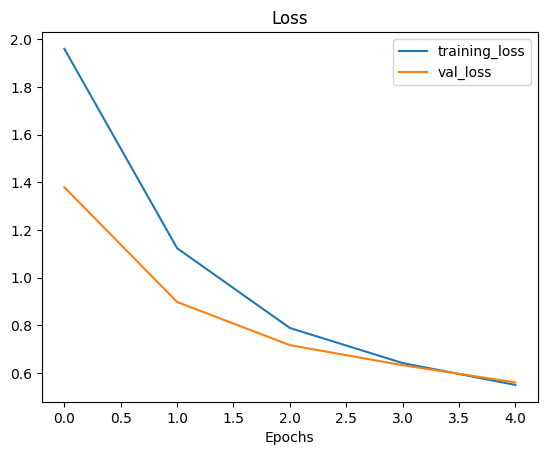

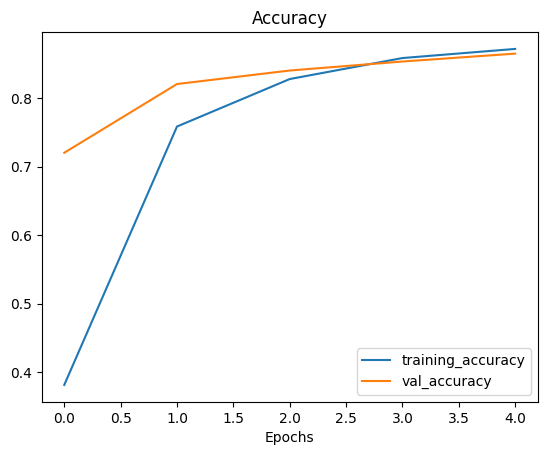

In [ ]:
#check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the GlobalAveragePooling2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7,7,1280...

But then when it passes through GlobalAveragePooling2D, it turns into (None,1280).

Let's use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D

In [ ]:
#Define the input shape
input_shape = (1,4,4,3)

#create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]


In [ ]:
#Pass the random tensor through the GlobalAveragePooling2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
global_average_pooled_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [ ]:
#check the shape of the different tensor
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled tensor: {global_average_pooled_tensor.shape}")

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled tensor: (1, 3)


In [ ]:
#Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

**Practice:** Try to do the same with the above 2 cells but this time use `GlobalMaxPooling2D` and see what happen

In [ ]:
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D() (input_tensor)
global_max_pooled_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

In [ ]:
tf.reduce_max(input_tensor, axis = [1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it do with 1% of the training data... how about we set up a bunch of experimets to find out:

1. `model_1` - use feature extraction transfer learning with 1% if the training data with data augmentation
2. `model_2` -  use feature extraction transger learning with 10% of the training with data augmentation
3. `model_3` - use fine-tuning transfer on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> **note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

## Getting and preprocessing data for model_1

In [ ]:
#download and unzip data - preprocess from food 101

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")


--2023-04-24 08:50:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 74.125.199.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M  49.9MB/s    in 2.6s    

2023-04-24 08:50:59 (49.9 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [ ]:
#Create training and test dir
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
#How many images are we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There a

In [ ]:
#setup dataloaders
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size = IMG_SIZE,
                                                                           batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augementation right into the model

To add data augmentation right into our model, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the Tensorflow Data Augmentation documentation:
https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

Off the top of our heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocssing of images (augmentation) happens on the GPU which is much faster then a CPU
* Image data augmentation only happen during training, so we can still export our whole model and use it elsewhere.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
    # preprocessing.Rescale(1./255) #Keep for models like ResNet50v2
], name = "data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)

(-0.5, 511.5, 511.5, -0.5)

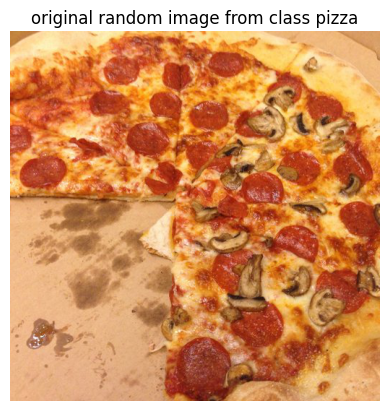

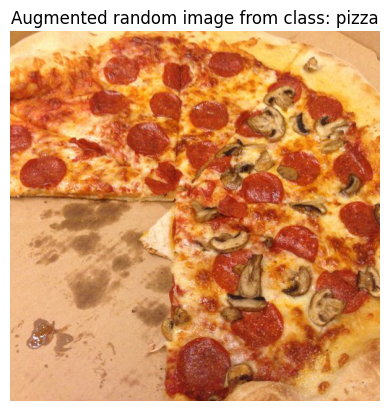

In [ ]:
#view a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mping
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir+"/"+random_image


#Read in the random image
img = mping.imread(random_image_path)
plt.imshow(img)
plt.title(f"original random image from class {target_class}")
plt.axis(False)

#now let's plot our augmented random image

augmented_img = data_augmentation(tf.expand_dims(img, axis = 0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)

In [ ]:

train_data_1_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation


In [ ]:
#Setup input shape and base model, freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

#Create input layer
inputs = layers.Input(shape = input_shape, name = "input_layer")

#add in data augmentation sequential model as a layer
x = data_augmentation(inputs)

#give base_model the inputs after augmentation and don't train it
x= base_model(x, training=False)

#Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

#Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name = "output_layer")(x)

#make a model using inputs and outputs
model_1 = keras.Model(inputs, outputs)

#compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

#fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs = 5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = (0.25*(len(test_data))),
                                callbacks = [create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230424-085106
Epoch 1/5
3/3 [==============================] - 12s 3s/step - loss: 2.4542 - accuracy: 0.0571 - val_loss: 2.2392 - val_accuracy: 0.1906
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1373 - accuracy: 0.2714 - val_loss: 2.0867 - val_accuracy: 0.2812
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9215 - accuracy: 0.4286 - val_loss: 1.9846 - val_accuracy: 0.3734
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.7843 - accuracy: 0.5714 - val_loss: 1.8776 - val_accuracy: 0.4313
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6230 - accuracy: 0.6429 - val_loss: 1.7811 - val_accuracy: 0.5047


In [ ]:
#Check out a model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
#Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 8s 91ms/step - loss: 1.7791 - accuracy: 0.4904


[1.779077172279358, 0.4903999865055084]

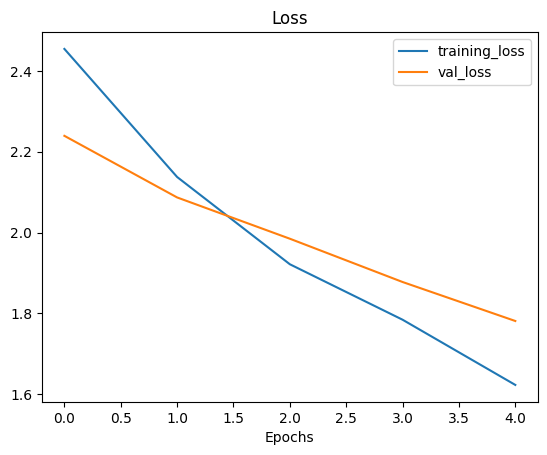

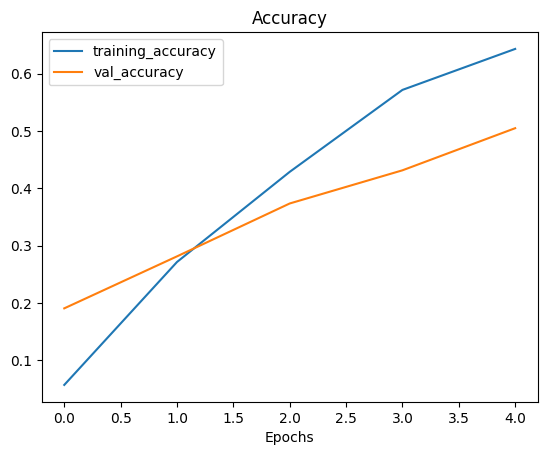

In [ ]:
#how does the model go with 1% of the data and data augmentation loss curves look?
plot_loss_curves(history_1_percent)

##Model 2: feature extraction transfer learning model with 10% of the training data

In [ ]:
# Get 10% of the data .... (we have already got it)
# !wget data_link
#unzip_data("data_path")
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
#how many images are in our directories?
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [ ]:
#set up data input
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode = "categorical",
                                                                            image_size = IMG_SIZE,
                                                                            batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
#create model 2 with data augmentation built-in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

#build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    #preprocessing.Rescaling(1/255.) #efficientnet already has rescaling but resnet doesnt so use this layer when using resnet
], name = "data_augmentation")



In [ ]:
#set up input shape
input_shape = (224,224,3)

#create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

#Create input layer and output layers (including the layers in between)
inputs = layers.Input(input_shape,name = "input_layer")

#Add data augmentation sequential model as a layer => augment our training data
x = data_augmentation(inputs)

#Add the augmentation data to the efficientnet layer
x = base_model(x, training = False) #add data to efficientnet but not alter its learned patterns => this also ensure the batchnorm layers don't get updated

#Add the pooling layer
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_2D_layer")(x)

#output layer
outputs = layers.Dense(10, activation = "softmax", name="output_layer")(x)

#create the model
model_2 = tf.keras.Model(inputs, outputs)

#compile the model
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])





###Create a model checkpoint callback

The ModelCheckpoint call back intermediately save our model (the full model or just the weights) during training. This is useful so we can come and start when we left off.

In [ ]:
#Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

#Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True,
                                                         save_betst_only = False,
                                                         save_freg = "epoch", #save every epoch
                                                         verbose = 1)

In [ ]:
#fit the model_2 passing in the model checkpoint callback
initial_epochs = 5

history_model_2 = model_2.fit(train_data_10_percent,
                              epochs = initial_epochs,
                              steps_per_epoch = len(train_data_10_percent),
                              validation_data = test_data,
                              validation_steps = int(0.25* len(test_data)),
                              callbacks = [create_tensorboard_callback("transfer_learning","10_percent_data_aug"), 
                                           checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230424-085154
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9817 - accuracy: 0.3520
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 22s 613ms/step - loss: 1.9817 - accuracy: 0.3520 - val_loss: 1.4495 - val_accuracy: 0.6859
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2837 - accuracy: 0.7160
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 14s 579ms/step - loss: 1.2837 - accuracy: 0.7160 - val_loss: 0.9826 - val_accuracy: 0.7895
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9907 - accuracy: 0.7693
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 396ms/step - loss: 0.9907 - accuracy: 0.7693 - val_loss: 0.7931 - val_accuracy: 0.8109
E

In [ ]:
#what were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 6s 69ms/step - loss: 0.5610 - accuracy: 0.8668


[0.5610498785972595, 0.8668000102043152]

In [ ]:
#check model_2 results on all test data
model_2.evaluate(test_data)

79/79 [==============================] - 6s 69ms/step - loss: 0.6180 - accuracy: 0.8432


[0.6180261969566345, 0.8432000279426575]

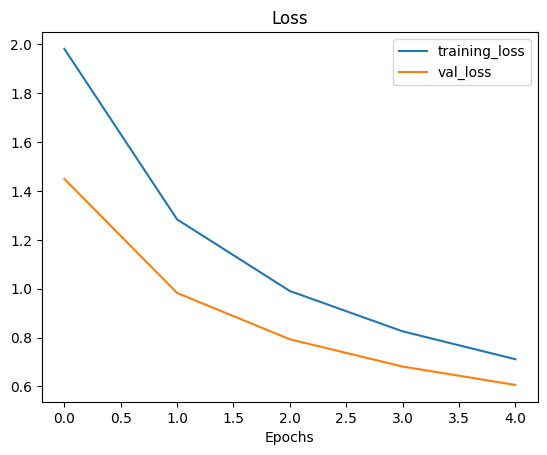

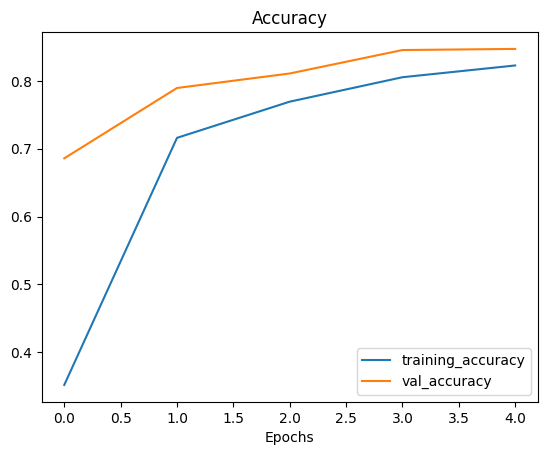

In [ ]:
#plot model lost curves
plot_loss_curves(history_model_2)

In [ ]:
results_10_percent_data_aug = model_2.evaluate(test_data)

79/79 [==============================] - 8s 95ms/step - loss: 0.6180 - accuracy: 0.8432


###Loading in checkpointed weights

Loading in checkpointed weights returns a model to a speicfic checkpoint

In [ ]:
#load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
#evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 69ms/step - loss: 0.6180 - accuracy: 0.8432


In [ ]:
#if the results from our previously evaluated model_2 match the loaded weights, everything has worked!
results_10_percent_data_aug == loaded_weights_model_results

False

In [ ]:
results_10_percent_data_aug

[0.6180262565612793, 0.8432000279426575]

In [ ]:
loaded_weights_model_results

[0.6180261969566345, 0.8432000279426575]

In [ ]:
#check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
#Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[5.96046448e-08 0.00000000e+00]


##Model 3: Fine-tuning an existing moddel on 10% of the data

>**Note:** Fine-tuning usally works best *after* training a feature extraction model for a few epoch with large amounts of custom data

In [ ]:
#layers in loaded model
model_2.layers

In [ ]:
#Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f0903f76f10> True
<keras.engine.sequential.Sequential object at 0x7f0914f7bb80> True
<keras.engine.functional.Functional object at 0x7f0903d357c0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f0903f76ca0> True
<keras.layers.core.dense.Dense object at 0x7f09901a2c70> True


In [ ]:
#what layers are in our base model and are they trainable?
for i,layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [ ]:
#How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
#load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
#to begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

#Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False


#recompile (we have to recompile our models every time we make a change)
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(lr=0.0001), #when fine-tuning => lower lr is required to prevent overfitting
                metrics = ["accuracy"])




/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>**Note:** When using fine-tuning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x (through different resources will claim other values).

A good resource for information on this is the ULMFit paper.

In [ ]:
#check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [ ]:
#Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_2.trainable_variables))

12


In [ ]:
#fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

#refit the model(same as model_2 except with more trainable layers)

history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               validation_data = test_data,
                                               validation_steps = int(0.25*len(test_data)),
                                               initial_epoch = history_model_2.epoch[-1], #start training from the last previous epoch
                                               callbacks = [create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")])



Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230424-085344
Epoch 5/10
24/24 [==============================] - 19s 490ms/step - loss: 0.6173 - accuracy: 0.8360 - val_loss: 0.4874 - val_accuracy: 0.8470
Epoch 6/10
24/24 [==============================] - 10s 393ms/step - loss: 0.4984 - accuracy: 0.8533 - val_loss: 0.4504 - val_accuracy: 0.8553
Epoch 7/10
24/24 [==============================] - 10s 419ms/step - loss: 0.4502 - accuracy: 0.8573 - val_loss: 0.4297 - val_accuracy: 0.8520
Epoch 8/10
24/24 [==============================] - 9s 339ms/step - loss: 0.3746 - accuracy: 0.8880 - val_loss: 0.4356 - val_accuracy: 0.8454
Epoch 9/10
24/24 [==============================] - 9s 369ms/step - loss: 0.3616 - accuracy: 0.8893 - val_loss: 0.4112 - val_accuracy: 0.8553
Epoch 10/10
24/24 [==============================] - 9s 350ms/step - loss: 0.3171 - accuracy: 0.9040 - val_loss: 0.4277 - val_accuracy: 0.8503


In [ ]:
#Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)

result_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 7s 76ms/step - loss: 0.4126 - accuracy: 0.8616


In [ ]:
results_10_percent_data_aug

[0.6180262565612793, 0.8432000279426575]

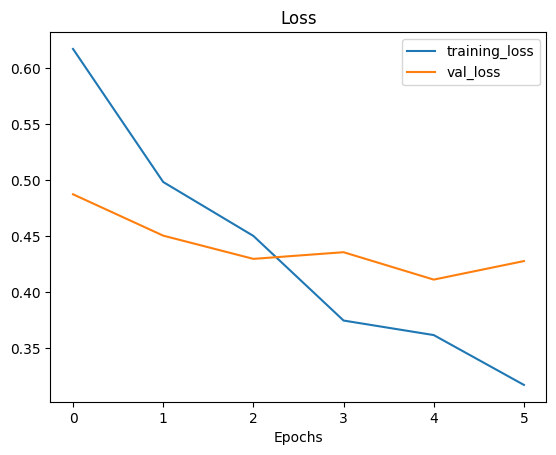

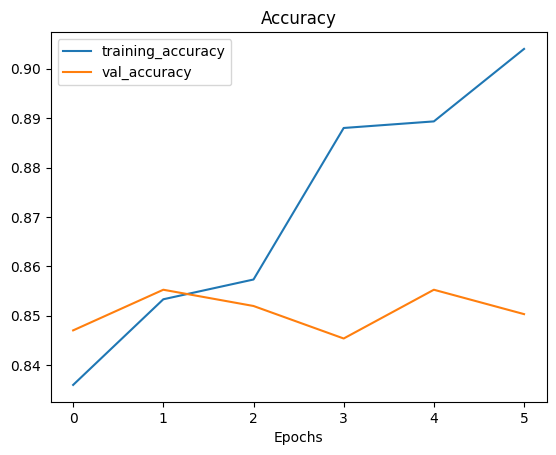

In [ ]:
# check out the loss curves of fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` functions works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning)

In [ ]:
#let's create a function to compare training histories
def compare_historys(original_history, new_history, initial_epochs = 5):
  """
  Compare two TensorFlow history objects.


  
  """

  #get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]
  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  #combine original history metrics with new_history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]
  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  #Make plots for accuracy
  plt.figure(figsize = (8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label="training accuracy")
  plt.plot(total_val_acc, label = "val accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start fine tuning")
  plt.legend(loc = "lower right")
  plt.title("training and validation accuracy")


  #Make plots for loss
  plt.figure(figsize = (8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label="training loss")
  plt.plot(total_val_loss, label = "val loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start fine tuning")
  plt.legend(loc = "upper right")
  plt.title("training and validation loss")

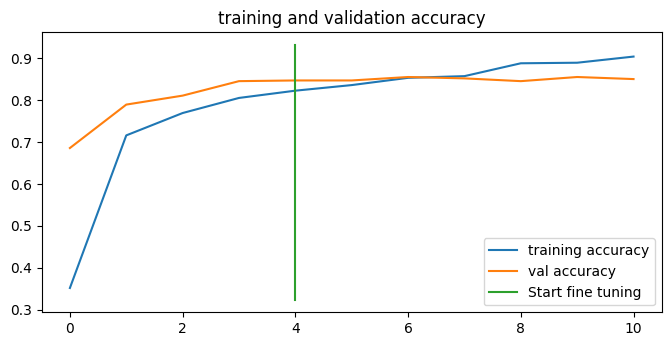

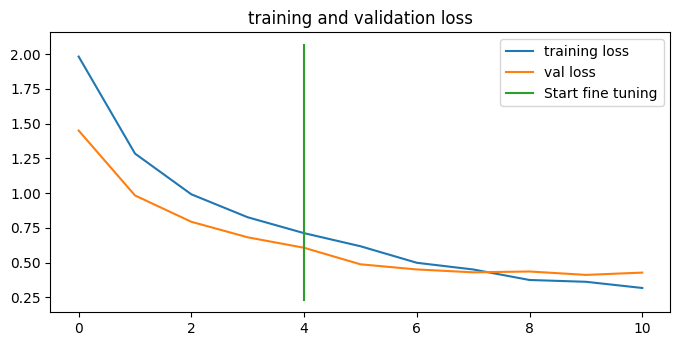

In [ ]:
compare_historys(history_model_2,
                 history_fine_10_percent_data_aug,
                 initial_epochs =5)

## Model 4: Fine-tuning and existing model on all of the data


In [ ]:
#download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2023-04-24 08:55:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.197.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.2’

10_food_classes_all 100%[===================>] 495.13M  87.6MB/s    in 4.4s    

2023-04-24 08:55:39 (112 MB/s) - ‘10_food_classes_all_data.zip.2’ saved [519183241/519183241]



In [ ]:
#setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
#How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 image_size = IMG_SIZE,
                                                                                 label_mode = "categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size = IMG_SIZE)




Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset).

let's verify this...


In [ ]:
#evaluate model 2 (this is the fine-tuned on 10% of data version)

model_2.evaluate(test_data)

79/79 [==============================] - 7s 86ms/step - loss: 0.4126 - accuracy: 0.8616


[0.4126199185848236, 0.8615999817848206]

In [ ]:
result_fine_tune_10_percent

[0.4126199185848236, 0.8615999817848206]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights.

In [ ]:
#load weights from checkpoint, that way we can fine-tune from the same 
#stage the 10% data model was fine-tuned from 

model_2.load_weights(checkpoint_path)

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 10s 106ms/step - loss: 0.6180 - accuracy: 0.8432


[0.6180261373519897, 0.8432000279426575]

In [ ]:
#check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6180262565612793, 0.8432000279426575]

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint`callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3)
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data (model_4)

In [ ]:
#check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D_layer True
4 output_layer True


In [ ]:
#let's drill into our base_model(efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [ ]:
#recompile 
model_2.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
                metrics = ["accuracy"])



/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#continue to train and fine-tuned the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs = fine_tune_epochs,
                                           validation_data = test_data,
                                           validation_steps = int(0.25*len(test_data)),
                                           initial_epoch = history_model_2.epoch[-1],
                                           callbacks = [create_tensorboard_callback("transfer_learning","full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230424-091349
Epoch 5/10
235/235 [==============================] - 74s 271ms/step - loss: 0.6671 - accuracy: 0.7848 - val_loss: 0.3097 - val_accuracy: 0.8947
Epoch 6/10
235/235 [==============================] - 56s 234ms/step - loss: 0.5298 - accuracy: 0.8311 - val_loss: 0.2515 - val_accuracy: 0.9112
Epoch 7/10
235/235 [==============================] - 56s 236ms/step - loss: 0.4628 - accuracy: 0.8537 - val_loss: 0.2787 - val_accuracy: 0.9079
Epoch 8/10
235/235 [==============================] - 49s 207ms/step - loss: 0.4256 - accuracy: 0.8625 - val_loss: 0.2540 - val_accuracy: 0.9095
Epoch 9/10
235/235 [==============================] - 47s 198ms/step - loss: 0.3915 - accuracy: 0.8752 - val_loss: 0.2489 - val_accuracy: 0.9194
Epoch 10/10
235/235 [==============================] - 46s 192ms/step - loss: 0.3625 - accuracy: 0.8803 - val_loss: 0.2641 - val_accuracy: 0.9013


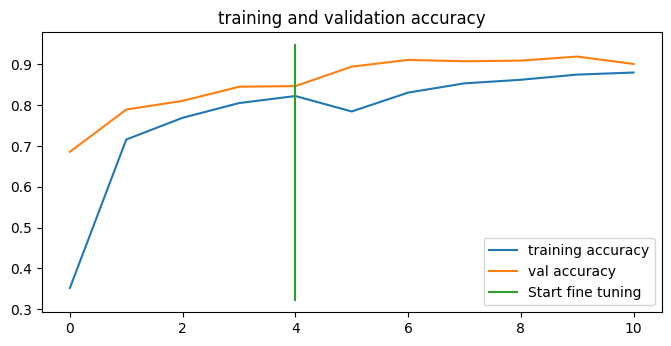

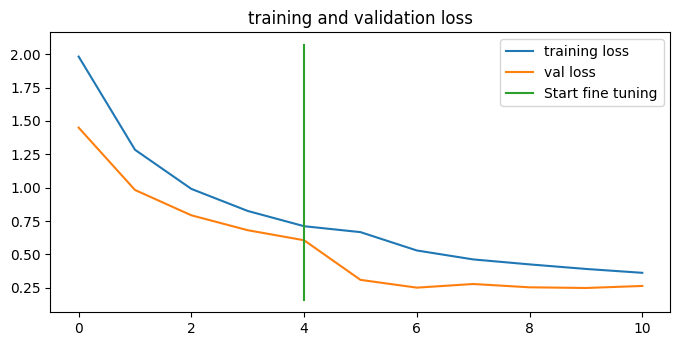

In [89]:
#how did fine-tuning go with more data?
compare_historys(original_history=history_model_2,
                 new_history = history_fine_10_classes_full,
                 initial_epochs = 5)

##Viewing our experiment data on tensorboard
> **note:** anything you upload on TensorBoard.dev is going to be public. so if you have private data, do not upload.


In [ ]:
#view tensorboard logs of transfer learning modelling experiments (should ~4 models)
#upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning --name "Transfer learning Experiments with 10 food101 classes" --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" --one_shot #exit the uploader once it finish the uploading



***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=xHt6x2qedOiSMAWXXnQ1sA4FSwn2jC&prompt=consent&access_type=o

In [ ]:
yesyes